## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv("./chronic_kidney_disease_full.csv")

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:

First, I want to check the ckd variable to see if unbalanced classes would be an issue here. (A 38/62 split probably won't be problematic.)

Secondly, since we want to predict ckd, I would probably want to compare each variable with ckd to see which variables appear to have predictive value.

Are any variables missing extensively so that it will be problematic? 


---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [3]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [4]:
#they all have nulls, but what columns have a high percentage? (over 15-20%)

100 * df.isnull().sum() / df.shape[0]

age       2.25
bp        3.00
sg       11.75
al       11.50
su       12.25
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [5]:
df.dropna(axis = 0, how = 'any', inplace = True)

In [6]:
df.shape

(158, 25)

In [7]:
# We'd drop 242 of our 400 observations (over 60% of our data!) by dropping each row that contains any missing value.

# Some downsides to this:

# Of these 242 rows, many of them do have information filled in for some of the cells. If we drop any observation that contains at least one missing value, then I'm discarding a lot of data that exists!
# If "NaN" possibly means something (i.e. this test was not run), then discarding cells might be a bad idea.
# By dropping values in this way, we drop 35 of our 150 "Not CKD" observations (23%) but drop 207 of our 250 "CKD" observations (83%!!!). This would affect the balance of our classes considerably and may create bias in our models.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

Certain variables may be subjective. For example, two different doctors might arrive at two different conclusions for "appetite." What qualifies as "good" versus "poor?"

For certain variables like "red blood cells," does it make sense to just leave it at "normal" versus "abnormal?" Are there multiple ways for red blood cells to be "abnormal?" This imprecision might make our test less effective than we'd like.

While we assume this isn't the case, it's always possible that the data we have are wrong.
Maybe lab results were mixed up (i.e. not connected to the correct patient).
Maybe machines aren't properly calibrated or some contamination occurred so our measurements are incorrect.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: An overly simplistic model would be to tell all people that they have CKD. Thus, no person would ever be told they do not have CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

In this problem, assuming that CKD is the "positive" class, we minimized false negatives. This is equivalent to maximizing sensitivity.


### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Telling every person they have CKD is unethical because then people will likely pursue expensive treatment options. It also causes lots of anxiety. In the long run, people would stop using your test because of all of the false positives.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple) model can I create that will accomplish this?

An overly simplistic model would be to tell no people that they have CKD. Thus, no person would ever be told they do have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

n this problem, assuming that CKD is the "positive" class, we minimized false positives. This is equivalent to maximizing specificity.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Telling every person they have CKD is unethical because then people will return home thinking they are healthy when they are not. This would likely result in deaths of patients. Additionally, in the long run, people would stop using your test because of all of the false negatives.



### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [8]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,ckd
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,ckd
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,ckd
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,ckd


In [9]:
df['y'] = [1 if i == 'ckd' else 0 for i in df['class']]

In [10]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,y
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,6700.0,3.9,yes,no,no,poor,yes,yes,ckd,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,...,12100.0,3.7,yes,yes,no,poor,no,yes,ckd,1
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,...,4500.0,3.8,yes,yes,no,poor,yes,no,ckd,1
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,...,11000.0,2.6,yes,yes,yes,poor,yes,no,ckd,1
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,...,9200.0,3.2,yes,yes,yes,poor,yes,yes,ckd,1


In [11]:
df['y'].value_counts()   #small dataset, imbalanced classes, may cause some problems

0    115
1     43
Name: y, dtype: int64

In [12]:
# let's look at pus count and pus count clumps since those sound like theyre correlated'

In [13]:
df['pc'].value_counts()

normal      129
abnormal     29
Name: pc, dtype: int64

In [14]:
df['pcc'].value_counts()

notpresent    144
present        14
Name: pcc, dtype: int64

In [15]:
df['pc'] = df['pc'].map(lambda x: 1 if x == 'abnormal' else 0)   #make dummies in line

In [16]:
df['pcc'] = df['pcc'].map(lambda x: 1 if x == 'present' else 0)

In [17]:
df['pc'].value_counts()

0    129
1     29
Name: pc, dtype: int64

In [18]:
df['pcc'].value_counts()

0    144
1     14
Name: pcc, dtype: int64

In [19]:
#^^^ let's only use one of these in the model - likely WAY too correlated

In [20]:
#now let's create an interaction term for blood cells!

df['wbcc_rbcc_interaction'] = df['wbcc'] * df['rbcc']

df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,rbcc,htn,dm,cad,appet,pe,ane,class,y,wbcc_rbcc_interaction
3,48.0,70.0,1.005,4.0,0.0,normal,1,1,notpresent,117.0,...,3.9,yes,no,no,poor,yes,yes,ckd,1,26130.0
9,53.0,90.0,1.020,2.0,0.0,abnormal,1,1,notpresent,70.0,...,3.7,yes,yes,no,poor,no,yes,ckd,1,44770.0
11,63.0,70.0,1.010,3.0,0.0,abnormal,1,1,notpresent,380.0,...,3.8,yes,yes,no,poor,yes,no,ckd,1,17100.0
14,68.0,80.0,1.010,3.0,2.0,normal,1,1,present,157.0,...,2.6,yes,yes,yes,poor,yes,no,ckd,1,28600.0
20,61.0,80.0,1.015,2.0,0.0,abnormal,1,0,notpresent,173.0,...,3.2,yes,yes,yes,poor,yes,yes,ckd,1,29440.0


In [21]:
df.dtypes

age                      float64
bp                       float64
sg                       float64
al                       float64
su                       float64
rbc                       object
pc                         int64
pcc                        int64
ba                        object
bgr                      float64
bu                       float64
sc                       float64
sod                      float64
pot                      float64
hemo                     float64
pcv                      float64
wbcc                     float64
rbcc                     float64
htn                       object
dm                        object
cad                       object
appet                     object
pe                        object
ane                       object
class                     object
y                          int64
wbcc_rbcc_interaction    float64
dtype: object

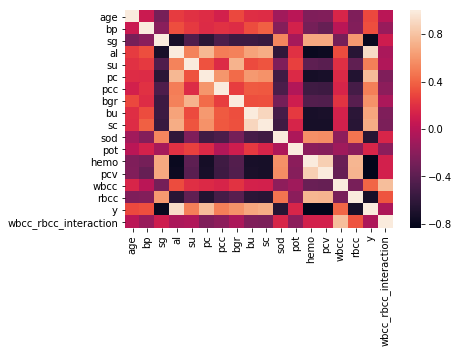

In [22]:
corr = df.corr()
sns.heatmap(corr)

In [23]:
#columns we want to use:

#age, bp, sg, al, su, pc, ba(binarize), bgr, sc, sod, pot, hemo, pcv, pe (binarize), wbcc_rbcc_interaction

In [24]:
df['pe'] = df['pe'].apply(lambda x: 1 if x == 'yes' else 0)

In [25]:
df['pe'].value_counts()

0    138
1     20
Name: pe, dtype: int64

In [26]:
df['ba'] = df['ba'].apply(lambda x: 1 if x == 'present' else 0)

In [27]:
df['ba'].value_counts()

0    146
1     12
Name: ba, dtype: int64

In [28]:
#now we've got our X values in almost proper form... let's define our matrix

# X = df[['age', 'bp', 'sg', 'al', 'su', 'pc', 'ba', 
#         'bgr', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'pe','wbcc_rbcc_interaction']]

X = df[['bgr', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'pe','wbcc_rbcc_interaction']]
y = df['y']

In [29]:
X.head()

,bgr,sc,sod,pot,hemo,pcv,pe,wbcc_rbcc_interaction
3,117.0,3.8,111.0,2.5,11.2,32.0,1,26130.0
9,70.0,7.2,114.0,3.7,9.5,29.0,0,44770.0
11,380.0,2.7,131.0,4.2,10.8,32.0,1,17100.0
14,157.0,4.1,130.0,6.4,5.6,16.0,1,28600.0
20,173.0,3.9,135.0,5.2,7.7,24.0,1,29440.0


In [30]:
# Now we need to TTS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [31]:
#since we're looking at all of these different quantities/qualities, we should probably standardize...

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)


In [32]:
#Now let's model! With GridSearchCV!

We know we want to use a logistic regression, so let's look at what hyperparameters we can tune with gridsearch and create our parameter dictionary!'

In [33]:
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [34]:
parameters  = {'C': [0.01, 0.1, 0.5, 1, 10],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

#where C is the inverse of regularization strength
# class_weight is if we want to try balancing our classes or not (worth trying since we have imbalanced classes)
#penalty is l1 (lasso) or l2 (ridge) regularization

In [35]:
gs_results = GridSearchCV(estimator = LogisticRegression(random_state = 42), # Specify the model we want to GridSearch.
                          param_grid = parameters,                           # Specify the grid of parameters we want to search.
                          scoring = 'recall',                                # Specify recall as the metric to optimize - The recall is the ratio tp / (tp + fn)
                          cv = 5).fit(Xs_train, y_train)                      # Set 5-fold cross-validation, then fit. (Default is 3.)

In [36]:
gs_results.best_estimator_


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
better_model = gs_results.best_estimator_


In [38]:
better_model.score(Xs_train, y_train)

0.99047619047619051

In [39]:
better_model.score(Xs_test, y_test)

0.98113207547169812

Based on the results of this GridSearch, our best model is that which:

Has an inverse regularization strength of C = 0.01.
Does not balance our class_weight (weighting our y variables so each class makes up 50%).
Has the L2 penalty (i.e. Ridge regression).

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [40]:
import numpy as np

In [41]:
list(zip(np.exp(better_model.coef_[0]),X.columns))

[(1.1822241654646846, 'bgr'),
 (1.1942768836280273, 'sc'),
 (0.85383357723518338, 'sod'),
 (0.98917669059618885, 'pot'),
 (0.81260170180054536, 'hemo'),
 (0.81263754581353309, 'pcv'),
 (1.1669218465906206, 'pe'),
 (1.0258333827593709, 'wbcc_rbcc_interaction')]

As serum creatinine (sc) increases by one unit (mgs/dl), an individual is 1.194 times as likely to have CKD, all else held equal.



### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

1.1669218465906206, 'pe'

If someone'has a pe, they are 1.1669 times as likely to have CKD, all else held equal.



### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Highly interpretable
Can prevent overfitting by using regularization

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [42]:
y_preds = better_model.predict(Xs_test)   #only really makes sense to do it on our test data

In [43]:
y_pred_proba = better_model.predict_proba(Xs_test)

In [44]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [45]:
def classifications(y_test, y_preds):
    print('Mean accuracy score %s ' % accuracy_score(y_test, y_preds))
    print(confusion_matrix(y_test, y_preds))
    print(classification_report(y_test, y_preds))

print(classifications(y_test, y_preds))

Mean accuracy score 0.981132075472 
[[39  0]
 [ 1 13]]
             precision    recall  f1-score   support

          0       0.97      1.00      0.99        39
          1       1.00      0.93      0.96        14

avg / total       0.98      0.98      0.98        53

None


In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

In [47]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 39

False Positives: 0

False Negatives: 1

True Positives: 13


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

We probably want to find some combination of sensitivity and specificity.

Focusing only on sensitivity means we minimize false negatives. This means there will be few people we incorrectly predict to be healthy, but more people we incorrectly predict to be sick.

Focusing only on specificity means we minimize false positives. This means there will be few people we incorrectly predict to be sick, but more people we incorrectly predict to be healthy.

I don't think sensitivity and specificity are equally important, though. I think sensitivity is more important (I'd rather tell people they have CKD and be wrong than tell people they're healthy and have them get sick.).

Four potential options I would consider in this case:

Just go with optimizing sensitivity, as it's better than optimizing specificity.

I might try to optimize f1-score, a combination of sensitivity and specificity.

I might try to optimize a custom metric that weighs sensitivity somewhat more importantly than specificity.

I might look at my ROC curve and try to find a place where sensitivity is very high and 1 - specificity is pretty low.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

1.0


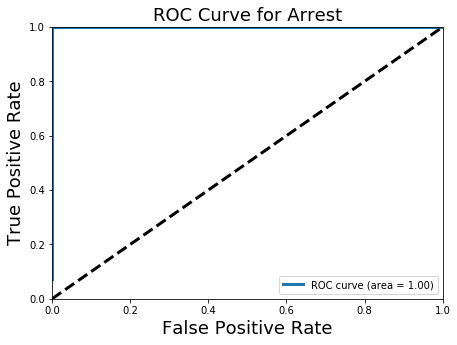

In [52]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

y_score = better_model.predict_proba(Xs_test)[:,1]

print(roc_auc_score(y_test, y_score))

FPR = dict()
TPR = dict()
ROC_AUC = dict()

roc_curve(y_test, y_score)  #will give arrays

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

#Plotting
plt.figure(figsize=[7,5])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve for Arrest', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Unbalanced classes are usually a problem because our model has a tough time learning about the minority class. There's simply not enough data to learn the "pattern" or "behavior" of the minority class.

They probably aren't a problem in this CKD analysis considering how accurate our model is

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Let's say you treat a patient who comes in with a broken arm. These happen pretty frequently, so you have a good idea of how to fix it, what potential complications are, etc. On the other hand, let's say you treat a patient who presents with odd symptoms that you've never seen before. You check books and do research, but it's very hard to understand this disease becauses you just don't have enough information to identify causes or recommend treatments.

That is the problem of unbalanced classes. When we build a model where we have lots of broken arms but very few "rare diseases," it's hard for our model to learn about those rare diseases because we see them so infrequently that we don't have enough information.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 3,600 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with about 4,000 observations, of which only 150 (3.75%) are non-CKD individuals.

In [53]:
ckd_sample = df[df['class'] == 'ckd'].sample(1600,               # sample n = 1600
                                               replace = True,     # sample with replacement
                                               random_state = 42)  # set random state

In [54]:
ckd_sample.head(10)   #this makes a dataframe where every class is ckd. we'll concat it with our original dataframe to DRASTICALLY skew our target variable

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,rbcc,htn,dm,cad,appet,pe,ane,class,y,wbcc_rbcc_interaction
229,59.0,50.0,1.010,3.0,0.0,normal,1,0,0,241.0,...,3.8,no,yes,no,good,1,no,ckd,1,59660.0
181,45.0,70.0,1.025,2.0,0.0,normal,1,1,0,117.0,...,3.7,no,no,no,good,0,no,ckd,1,70670.0
91,56.0,70.0,1.015,4.0,1.0,abnormal,0,0,0,210.0,...,5.6,no,no,no,good,0,no,ckd,1,70000.0
249,56.0,90.0,1.010,4.0,1.0,normal,1,1,0,176.0,...,2.1,yes,yes,no,poor,1,yes,ckd,1,11340.0
48,73.0,70.0,1.005,0.0,0.0,normal,0,0,0,70.0,...,3.5,yes,yes,no,good,1,no,ckd,1,66150.0
133,70.0,100.0,1.015,4.0,0.0,normal,0,0,0,118.0,...,8.0,yes,no,no,good,0,no,ckd,1,67200.0
229,59.0,50.0,1.010,3.0,0.0,normal,1,0,0,241.0,...,3.8,no,yes,no,good,1,no,ckd,1,59660.0
128,52.0,90.0,1.015,4.0,3.0,normal,1,0,0,224.0,...,2.9,yes,yes,no,good,0,yes,ckd,1,14500.0
147,60.0,60.0,1.010,3.0,1.0,normal,1,1,0,288.0,...,3.0,yes,no,no,poor,0,yes,ckd,1,45600.0
74,56.0,90.0,1.015,2.0,0.0,abnormal,1,0,0,129.0,...,3.4,yes,no,no,good,0,no,ckd,1,21760.0


In [55]:
df_2 = pd.concat([df, ckd_sample])

In [56]:
df_2.isnull().sum()

age                      0
bp                       0
sg                       0
al                       0
su                       0
rbc                      0
pc                       0
pcc                      0
ba                       0
bgr                      0
bu                       0
sc                       0
sod                      0
pot                      0
hemo                     0
pcv                      0
wbcc                     0
rbcc                     0
htn                      0
dm                       0
cad                      0
appet                    0
pe                       0
ane                      0
class                    0
y                        0
wbcc_rbcc_interaction    0
dtype: int64

In [57]:
df_2.shape

(1758, 27)

In [58]:
df_2['y'].value_counts()

1    1643
0     115
Name: y, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?

In [59]:
Xub = df_2[['bgr', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'pe','wbcc_rbcc_interaction']]
yub = df_2['y']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(Xub, yub, test_size = 0.33, random_state=42)

In [61]:
#scale is

s = StandardScaler()
Xs_training = s.fit_transform(X_train)
Xs_testing = s.transform(X_test)

In [62]:
#I'm going ot go back to that better_model and use that for the logistic regression so we can more clearly see how unbalanced classes effects the same model

In [63]:
better_model.fit(Xs_training, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
better_model.score(Xs_training, y_train)

0.99065420560747663

In [65]:
better_model.score(Xs_testing, y_test)

0.98623063683304646

In [66]:
##this is still a crazy good score... how can that be?? 

In [67]:
# let's look at our reports'

predictions = better_model.predict(Xs_testing) 

In [68]:
def classifications(y_test, predictions):
    print('Mean accuracy score %s ' % accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))

print(classifications(y_test, predictions))

Mean accuracy score 0.986230636833 
[[ 27   8]
 [  0 546]]
             precision    recall  f1-score   support

          0       1.00      0.77      0.87        35
          1       0.99      1.00      0.99       546

avg / total       0.99      0.99      0.99       581

None


In [69]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [70]:
print("True Negatives: " + str(tn))
print()
print("False Positives: " + str(fp))
print()
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))

True Negatives: 27

False Positives: 8

False Negatives: 0

True Positives: 546


In [71]:
#In this case, it seems as though unbalanced classes actually makes our model perform better. This will usually not happen. However, let's think through unbalanced classes.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!